In [77]:
import numpy as np
from numpy import exp, log, pi
from scipy.stats import ortho_group

from matplotlib import pyplot as plt

from tqdm import tnrange, tqdm_notebook

In [248]:
def hinton(matrix, max_weight=None, ax=None):
    """Draw Hinton diagram for visualizing a weight matrix."""
    ax = ax if ax is not None else plt.gca()

    if not max_weight:
        max_weight = 2 ** np.ceil(np.log(np.abs(matrix).max()) / np.log(2))

    ax.patch.set_facecolor('gray')
    ax.set_aspect('equal', 'box')
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())

    for (x, y), w in np.ndenumerate(matrix):
        color = 'white' if w > 0 else 'black'
        size = np.sqrt(np.abs(w) / max_weight)
        rect = plt.Rectangle([x - size / 2, y - size / 2], size, size,
                             facecolor=color, edgecolor=color)
        ax.add_patch(rect)

    ax.autoscale_view()
    ax.invert_yaxis()

In [78]:
N = 100000
D = 100
K = 10

In [79]:
mu = 3*np.random.randn(D)

In [441]:
U = ortho_group.rvs(D)
L = np.concatenate([np.random.gamma(20,0.5,10),np.random.gamma(0.1,0.1,90)])
L = np.sort(L)[::-1]
C = U.dot(np.diag(L)).dot(U.T)

$x \sim N(x|\mu,C)$
<br>
$X \in \mathbb{R}^{N \times D}$

In [442]:
X = np.random.multivariate_normal(mu,C,N)
X.shape

(100000, 100)

# Samples briefing

In [443]:
mu_est = X.mean(0)

$Y = X - \bar{X}$

In [444]:
Y = X - mu_est

$S = \dfrac{1}{N}Y^T Y $

In [445]:
S = (Y.T).dot(Y)/N

In [446]:
L_est,U_est = np.linalg.eigh(S)
idx = np.argsort(L_est)[::-1]
L_est = L_est[idx]
U_est = U_est[:,idx]

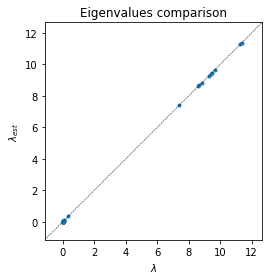

In [447]:
limits = [0, max(L[0],L_est[0])]
limits[0] -= 0.1*(limits[1] - limits[0])
limits[1] += 0.1*(limits[1] - limits[0])
plt.plot(L,L_est,'.')
plt.plot(limits, limits,'k--',lw=0.5)
plt.axis('square')
plt.xlim(limits)
plt.ylim(limits)
plt.xlabel('$\lambda$')
plt.ylabel('$\lambda_{est}$')
plt.title('Eigenvalues comparison')
plt.show()

In [448]:
plt.plot(np.array([abs(U[:,i].dot(U_est[:,i])) for i in range(D)]),'.')
plt.axvline(-0.5,ls='--',lw=0.5,color='k')
plt.axvline(4.5,ls='--',lw=0.5,color='k')
plt.axvline(9.5,ls='--',lw=0.5,color='k')
plt.axvline(99.5,ls='--',lw=0.5,color='k')
plt.title('Eigenvectors correspondence')
plt.xlabel('Index ($\lambda$ desc.)')
plt.show()

# Maximum likelihood PCA

$\sigma^2=(D-K)^{-1} \sum^D_{K+1} \lambda_k$ <br>
$W = U_K(\Lambda_K-\sigma^2I)^{1/2}$ <br>

In [449]:
K_ml = 10

var_ml = L_est[K_ml:].mean()
W_ml = U_est[:,:K_ml].dot(np.diag((L_est[:K_ml]-var_ml)**0.5))
C_ml = W_ml.dot(W_ml.T) + var_ml*np.identity(D)
M_ml = (W_ml.T).dot(W_ml) + var_ml*np.identity(K_ml)

# EM PCA

### E-step
- $M = W^T W + \sigma^2 I$
- $E[Z] = Y W M^{-1}$
- $\sum E[z_n z_n^T] = N \sigma^2 M^{-1} + E[Z]^T E[Z]$

### M-step
- $W = Y^T E[Z](\sum E[z_n z_n^T])^{-1}$
- $\sigma^2 = (ND)^{-1}\{ \lVert Y \rVert ^2 - tr(W^T Y^T E[Z])\}$

In [462]:
K_em = 50
T = 5000
energy = np.zeros(T)
tref = 0

W_em = np.random.randn(D,K_em)
var_em = np.random.gamma(1)
for t in tnrange(T):
    M_em = (W_em.T).dot(W_em) + var_em*np.identity(K_em)
    M_em_inv = np.linalg.inv(M_em)

    Ez = np.linalg.multi_dot([Y, W_em, M_em_inv])
    Cz = (N * var_em) * M_em_inv + (Ez.T).dot(Ez)
    
    tmp = (Y.T).dot(Ez)
    
    W_em = tmp.dot(np.linalg.inv(Cz))
    
    var_em = ((Y**2).sum() - (W_em*tmp).sum())/(D*N)
    
    energy[t] = N*D*log(var_em) + Cz.trace()

    if abs((energy[t] - energy[tref])/energy[tref]) > 1e-4:
        tref = t
    elif t - tref > 100:
        T = t+1
        print(f'@ iter {t+1}: Terminate due to convergence')
        break

KeyboardInterrupt: 

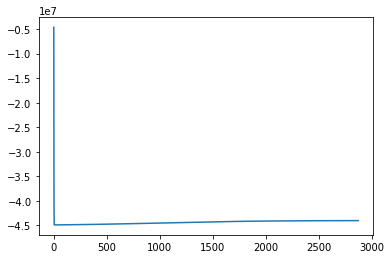

In [457]:
plt.plot(energy[:T])

In [458]:
C_em = W_em.dot(W_em.T) + var_em*np.identity(D)

In [459]:
L_em, U_em = np.linalg.eigh(C_em)
idx = np.argsort(L_em)[::-1]
L_em = L_em[idx]
U_em = U_em[:,idx]

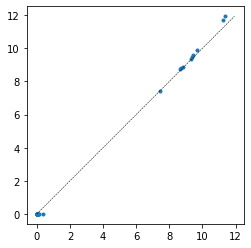

In [460]:
vmin = min(L_est[-1],L_em[-1])
vmax = max(L_est[0],L_em[0])
plt.plot(L_est, L_em, '.')
plt.plot([vmin,vmax],[vmin,vmax],'k--',lw=0.5)
plt.axis('square')
plt.show()

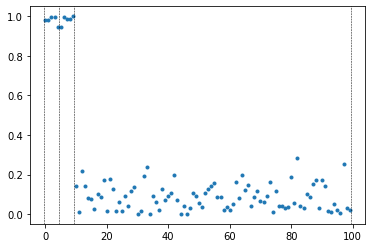

In [461]:
plt.plot([abs(U_est[:,i].dot(U_em[:,i])) for i in range(D)], '.')
plt.axvline(-0.5,ls='--',lw=0.5,color='k')
plt.axvline(4.5,ls='--',lw=0.5,color='k')
plt.axvline(9.5,ls='--',lw=0.5,color='k')
plt.axvline(99.5,ls='--',lw=0.5,color='k')
plt.show()

# ARD

- $\alpha_i^{-1} = \dfrac{\lVert w_i \rVert ^2}{D}$
- $A = diag(\alpha_i)$
- $W = Y^T E[Z] (\sum E[z_n z_n^T] + \sigma^2 A)^{-1}$

In [432]:
K_ard = D-1
T = 20000
energy = np.zeros(T)
tref = 0

W_ard = np.random.randn(D,K_ard)
var_ard = 0
for t in tnrange(T):
    M_ard = (W_ard.T).dot(W_ard) + var_ard*np.identity(K_ard)
    M_ard_inv = np.linalg.inv(M_ard)

    Ez = np.linalg.multi_dot([Y, W_ard, M_ard_inv])
    Cz = (N * var_ard) * M_ard_inv + (Ez.T).dot(Ez)
    
    alpha = D / (W_ard**2).sum(0)
    #alpha[alpha>100] = np.inf
    
    tmp = (Y.T).dot(Ez)
    
    W_ard = tmp.dot(np.linalg.inv(Cz + var_ard * np.diag(alpha)))
    
    #var_ard = ((Y**2).sum() + (W_ard*(W_ard.dot(Cz)-2*tmp)).sum())/(D*N)
    var_ard = ((Y**2).sum() - (W_ard*tmp).sum())/(D*(N+K_ard))
    
    energy[t] = N*D*log(var_ard) + Cz.trace()
    
    if abs((energy[t] - energy[tref])/energy[tref]) > 1e-4:
        tref = t
    elif t - tref > 100:
        T = t+1
        print(f'@ iter {t+1}: Terminate due to convergence')
        break

@ iter 7987: Terminate due to convergence


In [433]:
plt.plot(energy[:T])

In [434]:
idx = np.argsort(alpha)
alpha = alpha[idx]
W_ard = W_ard[:,idx]

In [435]:
hinton(W_ard.T)

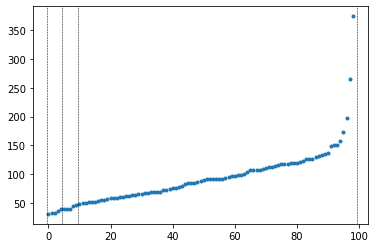

In [436]:
plt.plot(alpha,'.')
plt.axvline(-0.5,ls='--',lw=0.5,color='k')
plt.axvline(4.5,ls='--',lw=0.5,color='k')
plt.axvline(9.5,ls='--',lw=0.5,color='k')
plt.axvline(99.5,ls='--',lw=0.5,color='k')

In [437]:
C_ard = W_ard.dot(W_ard.T) + var_ard*np.identity(D)

In [438]:
L_ard, U_ard = np.linalg.eigh(C_ard)
idx = np.argsort(L_ard)[::-1]
L_ard = L_ard[idx]
U_ard = U_ard[:,idx]

(-1.5111432594586431, 16.773690179990936)

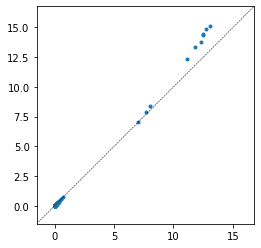

In [439]:
limits = [0, max(L[0], L_ard[0])]
limits[0] -= 0.1*(limits[1] - limits[0])
limits[1] += 0.1*(limits[1] - limits[0])

plt.plot(L_est, L_ard, '.')
plt.plot(limits, limits, 'k--', lw=0.5)
plt.axis('square')
plt.xlim(limits)
plt.ylim(limits)

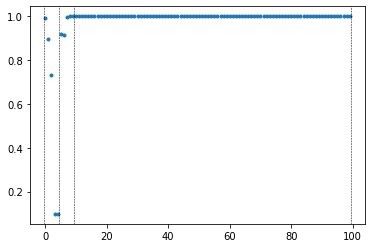

In [440]:
plt.plot([abs(U_est[:,i].dot(U_ard[:,i])) for i in range(D)], '.')
plt.axvline(-0.5,ls='--',lw=0.5,color='k')
plt.axvline(4.5,ls='--',lw=0.5,color='k')
plt.axvline(9.5,ls='--',lw=0.5,color='k')
plt.axvline(99.5,ls='--',lw=0.5,color='k')